In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(theme='grade3')

In [2]:
#User-supplied
obsfile = '/glade/p/work/manab/fcast/data/dly/obsflow.dly.HHDW1.csv'
summaoutfile = '/glade/p/work/manab/fcast/PNW/output/7468_jan28/PNW_output_H7468_timestep.nc'
routefile = '/glade/p/work/manab/SHARP/PNW_route/output/paramtest21.nc'

hid = 17007511  #HRU ID to be plotted
sid = 17003601  #Reach ID to be plotted
pltwidth = 15
pltheight = 5
starttime1 = '2010-10-01'
endtime1 = '2016-09-01'

In [5]:
# Observed streamflow
o = pd.read_csv(obsfile)
o.rename(columns = {'Year':'time', 'cfs': 'flow'}, inplace=True)

o['flow'] = o['flow']*0.028316847 #Convert to CMS
o['time'] = pd.to_datetime(o['time'])  #convert to datetime format
o.loc[o['flow'] < 0 , 'flow'] = np.nan
o.fillna(method='ffill', limit=10)

o = o.set_index(['time'])
obs = o.to_xarray()

In [6]:
#Unit conversion
out = xr.open_dataset(summaoutfile).set_index(hru = 'hruId')

#Convert gru unit to hru unit
runoffdata = out['averageInstantRunoff'].values                     #Extract averageInstantRunoff values
runoffarray = xr.DataArray(runoffdata, dims=['time','hru'])            #Create an array of averageInstantRunoff with 2 dimensions
out = out.drop('averageInstantRunoff')                           #Drop the original averageInstantRunoff variable
out['averageInstantRunoff'] = runoffarray                           #Add the new array to original netCDF
out['averageInstantRunoff'].attrs['long_name'] = "instantaneous runoff (instant)"
out['averageInstantRunoff'].attrs['units'] = 'm s-1'
        
out

<xarray.Dataset>
Dimensions:                 (hru: 1, midToto: 8, time: 19248)
Coordinates:
  * hru                     (hru) int64 17007511
  * time                    (time) datetime64[ns] 2010-06-01 ...
Dimensions without coordinates: midToto
Data variables:
    pptrate                 (time, hru) float64 ...
    nSnow                   (time, hru) int32 ...
    nSoil                   (time, hru) int32 ...
    nLayers                 (time, hru) int32 ...
    numberFluxCalc          (time, hru) int32 ...
    scalarSWE               (time, hru) float64 ...
    mLayerVolFracLiq        (time, midToto, hru) float64 ...
    scalarAquiferStorage    (time, hru) float64 ...
    scalarTotalSoilWat      (time, hru) float64 ...
    scalarRainPlusMelt      (time, hru) float64 ...
    scalarSurfaceRunoff     (time, hru) float64 ...
    scalarSoilBaseflow      (time, hru) float64 ...
    scalarSoilDrainage      (time, hru) float64 ...
    scalarAquiferRecharge   (time, hru) float64 ...
    scala

In [7]:
out['pptrate'] = out['pptrate']*3600      #kg m-2 s-1 -> mm/hr
out['averageInstantRunoff'] = out['averageInstantRunoff']*3600000  #m/s to mm/h
out['scalarAquiferBaseflow'] = out['scalarAquiferBaseflow']*3600000  #m/s to mm/h
out['scalarRainPlusMelt'] = out['scalarRainPlusMelt']*3600000  #m/s to mm/h
out['scalarAquiferRecharge'] = out['scalarAquiferRecharge']*3600000  #m/s to mm/h
out['scalarAquiferStorage'] = out['scalarAquiferStorage']*1000  #m to mm
out['scalarAquiferTranspire'] = out['scalarAquiferTranspire']*3600000  #m/s to mm/h
out['scalarSurfaceRunoff'] = out['scalarSurfaceRunoff']*3600000  #m/s to mm/h

# Summary Statistics (20101001 - 20160901)

In [8]:
param = {}
param['aquiferScaleFactor (Smax)'] = '3'
param['aquiferBaseflowRate(K)'] = '0.1'
param['aquiferBaseflowExp(c)'] = '1.5'

statsum = {}
statsum['pptrate (mm/h)'] = out['pptrate'].loc[starttime1:endtime1].sum().values
statsum['averageInstantRunoff (mm/h)'] = out['averageInstantRunoff'].loc[starttime1:endtime1].sum().values
statsum['scalarRainPlusMelt (mm/h)'] = out['scalarRainPlusMelt'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferRecharge (mm/h)'] = out['scalarAquiferRecharge'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferBaseflow (mm/h)'] = out['scalarAquiferBaseflow'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferStorage (mm)'] = out['scalarAquiferStorage'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferTranspire (mm/h)'] = out['scalarAquiferTranspire'].loc[starttime1:endtime1].sum().values

statavg = {}
statavg['pptrate (mm/h)'] = out['pptrate'].loc[starttime1:endtime1].mean().values
statavg['averageInstantRunoff (mm/h)'] = out['averageInstantRunoff'].loc[starttime1:endtime1].mean().values
statavg['scalarRainPlusMelt (mm/h)'] = out['scalarRainPlusMelt'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferRecharge (mm/h)'] = out['scalarAquiferRecharge'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferBaseflow (mm/h)'] = out['scalarAquiferBaseflow'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferStorage (mm)'] = out['scalarAquiferStorage'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferTranspire (mm/h)'] = out['scalarAquiferTranspire'].loc[starttime1:endtime1].mean().values

#totalbaseflow = statsum['scalarAquiferBaseflow (mm/h)'] 
#totalstreamflow = out.sel(hru = hid)['scalarAquiferRecharge'].loc[starttime1:endtime1].sum().values

#bfi = totalbaseflow / totalstreamflow
#print(bfi)

print('\n BASEFLOW PARAMETERS')
for x in param:
    print (x,':',param[x])
    
    
print('\n SUM')
for x in statsum:
    print (x,':',statsum[x])
    
print('\n AVERAGE')
for x in statavg:
    print (x,':',statavg[x])


 BASEFLOW PARAMETERS
aquiferScaleFactor (Smax) : 3
aquiferBaseflowRate(K) : 0.1
aquiferBaseflowExp(c) : 1.5

 SUM
pptrate (mm/h) : 4094.2294403329893
averageInstantRunoff (mm/h) : 7815.9517905182
scalarRainPlusMelt (mm/h) : 3589.4263034175215
scalarAquiferRecharge (mm/h) : 3907.9612114387346
scalarAquiferBaseflow (mm/h) : 3907.990579079458
scalarAquiferStorage (mm) : 3366.955246483139
scalarAquiferTranspire (mm/h) : 0.0

 AVERAGE
pptrate (mm/h) : 0.23660595471180013
averageInstantRunoff (mm/h) : 0.45168468507386733
scalarRainPlusMelt (mm/h) : 0.20743332775182163
scalarAquiferRecharge (mm/h) : 0.22584149395739336
scalarAquiferBaseflow (mm/h) : 0.22584319111647352
scalarAquiferStorage (mm) : 0.19457670171539176
scalarAquiferTranspire (mm/h) : 0.0


In [9]:
out['scalarSurfaceRunoff']

<xarray.DataArray 'scalarSurfaceRunoff' (time: 19248, hru: 1)>
array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])
Coordinates:
  * hru      (hru) int64 17007511
  * time     (time) datetime64[ns] 2010-06-01 2010-06-01T03:00:00 ...

# PLOTS

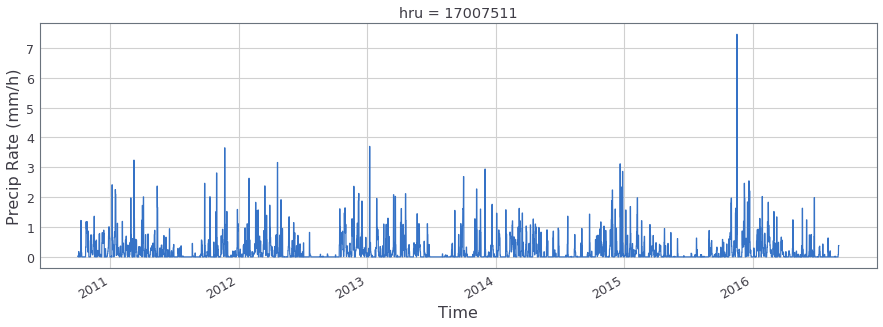

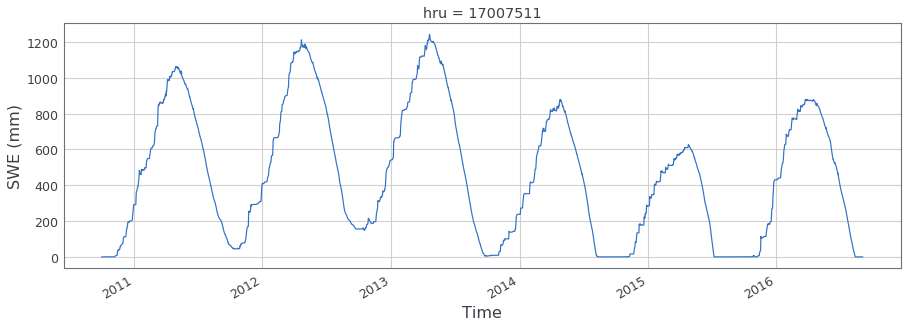

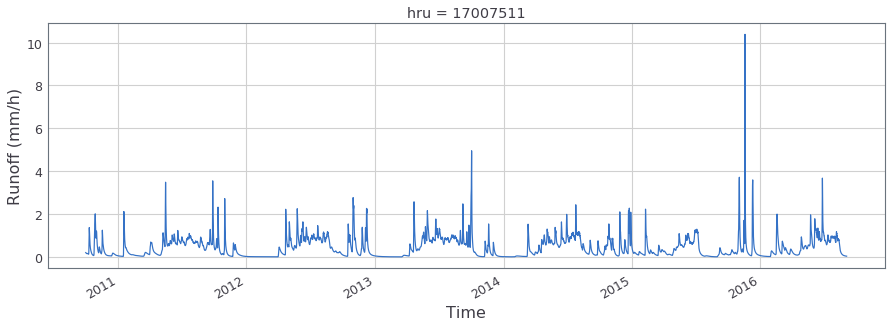

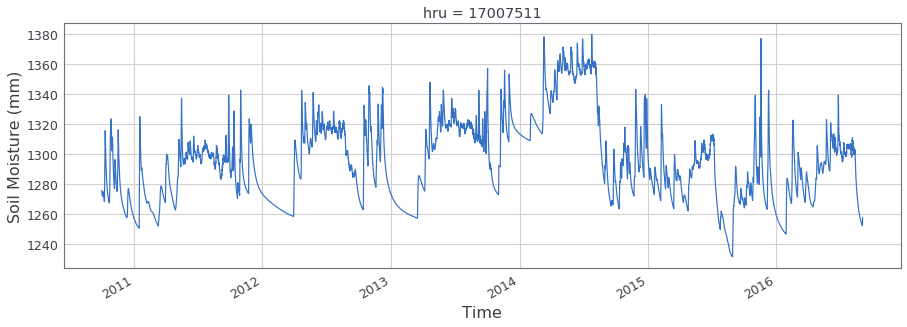

In [10]:
#Plot forcing and diagnostic variables


# PPTRATE
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['pptrate'].loc[starttime1:endtime1].plot()
plt.ylabel('Precip Rate (mm/h)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/pptrate.png', bbox_inches='tight', dpi=300)
plt.show()

# SWE
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarSWE'].loc[starttime1:endtime1].plot()
plt.ylabel('SWE (mm)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/swe.png', bbox_inches='tight', dpi=300)
plt.show()

#averageInstantRunoff
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['averageInstantRunoff'].loc[starttime1:endtime1].plot()
plt.ylabel('Runoff (mm/h)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/runoff.png', bbox_inches='tight', dpi=300)
plt.show()

#scalarTotalSoilWat
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarTotalSoilWat'].loc[starttime1:endtime1].plot()
plt.ylabel('Soil Moisture (mm)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/sm.png', bbox_inches='tight', dpi=300)
plt.show()



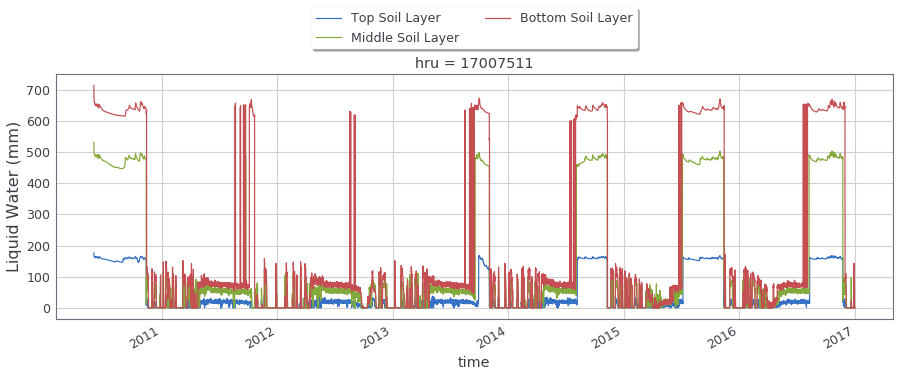

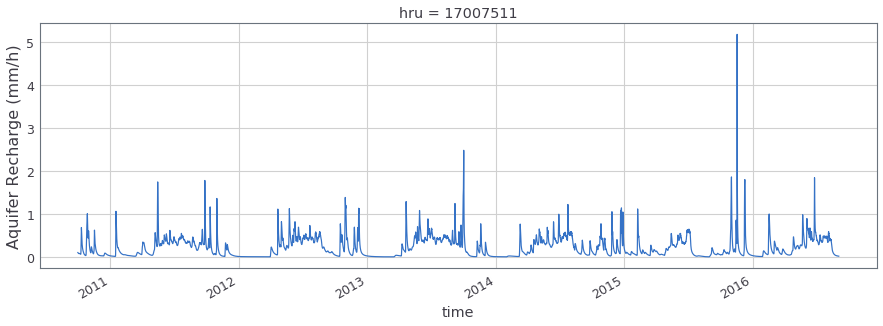

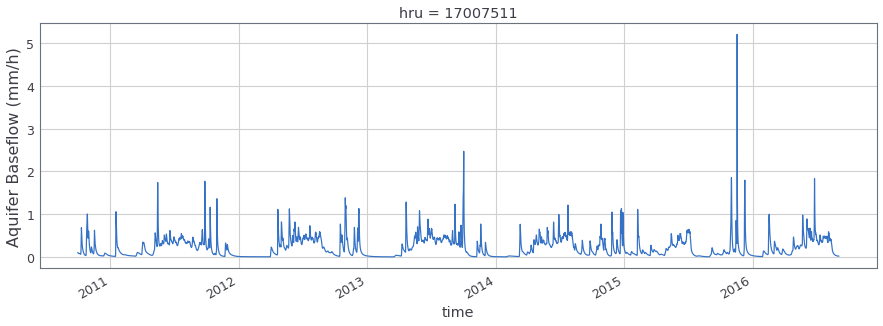

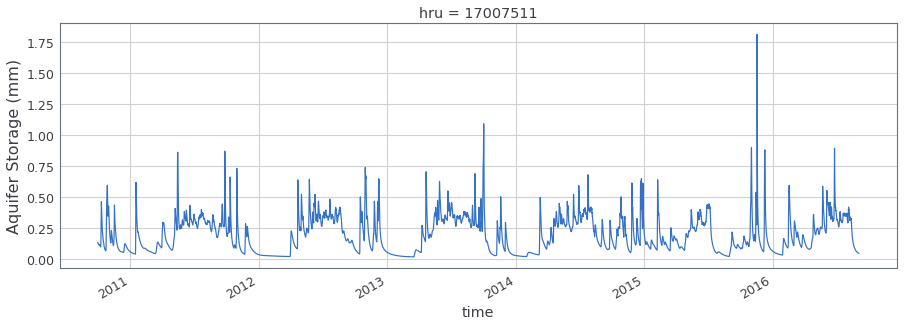

In [11]:
#mLayerVolFracLiq
iden_water = 1000
plt.figure(figsize=(pltwidth, pltheight))
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 0]*iden_water*0.5).plot(label='Top Soil Layer')
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 1]*iden_water*1.5).plot(label='Middle Soil Layer')
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 2]*iden_water*2.0).plot(label='Bottom Soil Layer')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fancybox=True, shadow=True)
plt.ylabel('Liquid Water (mm)', fontsize=16) 
plt.show()


plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarAquiferRecharge'].loc[starttime1:endtime1].plot()
plt.ylabel('Aquifer Recharge (mm/h)', fontsize=16)
plt.show()


plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarAquiferBaseflow'].loc[starttime1:endtime1].plot()
plt.ylabel('Aquifer Baseflow (mm/h)', fontsize=16)
plt.show()

plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarAquiferStorage'].loc[starttime1:endtime1].plot()
plt.ylabel('Aquifer Storage (mm)', fontsize=16)
plt.show()
